#### Importing Libraries

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from googletrans import Translator

In [25]:
!pip install googletrans

### Reading Files

In [9]:
train_path = "/kaggle/input/dataset/prep2_train.csv"
dev_path = "/kaggle/input/dataset/prep1_dev.csv"

train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)

## Data Integrity & Structure

In [10]:
print("Train Shape:", train.shape)
print("Dev Shape:", dev.shape)


print("\nTrain Columns:")
print(train.dtypes)


print("\nDev Columns:")
print(dev.dtypes)


print("\nMissing Values (Train):")
print(train.isnull().sum())


print("\nMissing Values (Dev):")
print(dev.isnull().sum())


print("\nDuplicate Rows (Train):", train.duplicated().sum())
print("Duplicate Rows (Dev):", dev.duplicated().sum())


print("\nSample Train Rows:")
print(train.head())


print("\nSample Dev Rows:")
print(dev.head())

Train Shape: (4040, 4)
Dev Shape: (2012, 4)

Train Columns:
id              object
text            object
polarization     int64
language        object
dtype: object

Dev Columns:
id               object
text             object
polarization    float64
language         object
dtype: object

Missing Values (Train):
id              0
text            0
polarization    0
language        0
dtype: int64

Missing Values (Dev):
id                 0
text               0
polarization    2012
language           0
dtype: int64

Duplicate Rows (Train): 0
Duplicate Rows (Dev): 0

Sample Train Rows:
                                     id  \
0  hau_1c40ceef36fad59132cbdcd4e3e7ead2   
1  ita_e87898075b379cd7bd927d75415c2479   
2  nep_1f285c299dfe50268a433b196033225e   
3  nep_f7a295adf5eb8f43529dfc3e4e3cd6e0   
4  tur_dd460b158797fec6ff360da2e8c28f5c   

                                                text  polarization language  
0  @USER bana goyon bayan tankawa kasakasai a sm....             0      

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## Label Distribution

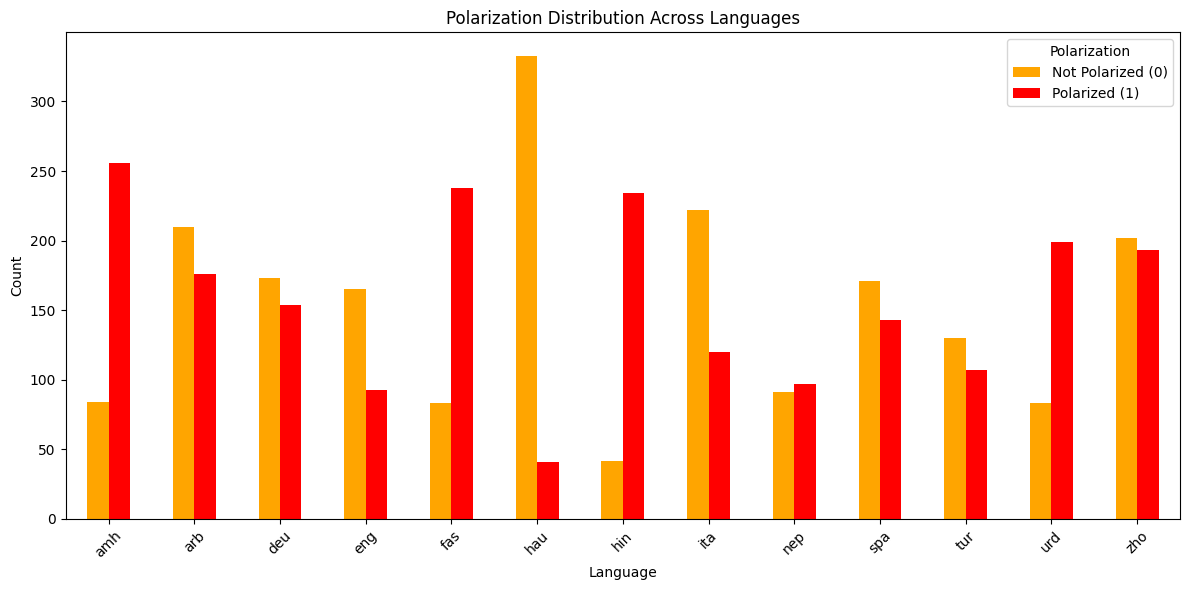

In [11]:
lang_label_counts = train.groupby(['language', 'polarization']).size().unstack(fill_value=0)

lang_label_counts.plot(kind='bar', figsize=(12, 6), color=['orange', 'red'])

plt.title("Polarization Distribution Across Languages")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Polarization", labels=['Not Polarized (0)', 'Polarized (1)'])

plt.tight_layout()
plt.show()

## Token Length Statistics

In [12]:
train["token_len"] = train["text"].str.split().str.len()
dev["token_len"] = dev["text"].str.split().str.len()

def token_length_stats(df, name):
    stats = df.groupby("language")["token_len"].agg(
        count='count',
        mean='mean',
        median='median',
        min='min',
        max='max'
    ).reset_index()
    stats["dataset"] = name
    return stats

train_stats = token_length_stats(train, "train")
dev_stats = token_length_stats(dev, "dev")

all_stats = pd.concat([train_stats, dev_stats], ignore_index=True)

print(all_stats)

   language  count       mean  median  min  max dataset
0       amh    340  14.947059    15.0    5   29   train
1       arb    386  17.044041    16.0    5   67   train
2       deu    327  16.724771    13.0    3  137   train
3       eng    258  12.709302     9.0    5   53   train
4       fas    321  19.271028    16.0    4   65   train
5       hau    374  20.278075    15.0    1  249   train
6       hin    276  26.884058    21.0    1   80   train
7       ita    342  21.961988    19.0    4   63   train
8       nep    188  17.441489    16.0    6   50   train
9       spa    314  10.640127     9.0    3   25   train
10      tur    237  20.919831    19.0    5   45   train
11      urd    282  18.624113    18.0    7   33   train
12      zho    395   1.202532     1.0    1    7   train
13      amh    166  15.560241    16.0    5   30     dev
14      arb    169  17.301775    16.0    5   58     dev
15      deu    159  18.767296    13.0    3  116     dev
16      eng    133  11.932331     9.0    5   48 

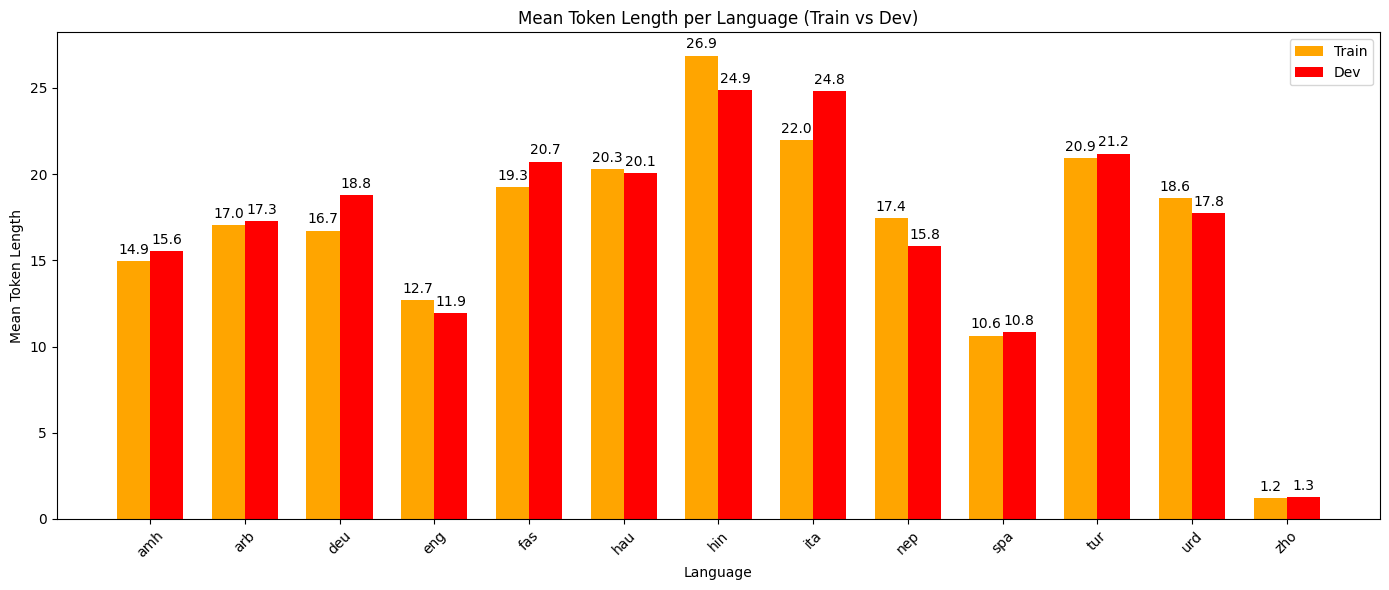

In [13]:
train["token_len"] = train["text"].str.split().str.len()
dev["token_len"] = dev["text"].str.split().str.len()

train_stats = train.groupby("language")["token_len"].agg(['mean', 'median', 'min', 'max']).reset_index()
dev_stats = dev.groupby("language")["token_len"].agg(['mean', 'median', 'min', 'max']).reset_index()

x = np.arange(len(train_stats))
width = 0.35

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, train_stats['mean'], width, label='Train', color='orange')
rects2 = ax.bar(x + width/2, dev_stats['mean'], width, label='Dev', color='red')

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

ax.set_xlabel('Language')
ax.set_ylabel('Mean Token Length')
ax.set_title('Mean Token Length per Language (Train vs Dev)')
ax.set_xticks(x)
ax.set_xticklabels(train_stats['language'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

## Vocabulary Analysis & Top N-grams

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TRAIN DATA — ALL LANGUAGES VOCABULARY
Total tokens: 76,207
Unique vocabulary: 26,311
Type-token ratio: 0.3453
DEV DATA — ALL LANGUAGES VOCABULARY
Total tokens: 37,976
Unique vocabulary: 15,392
Type-token ratio: 0.4053

Merged train + dev dataset contains: 6052 rows


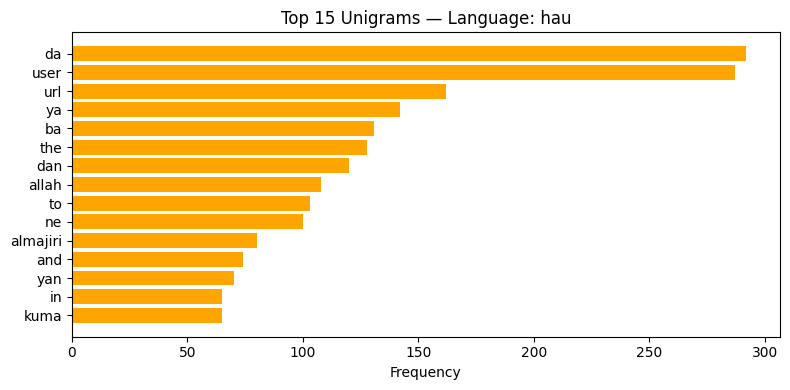

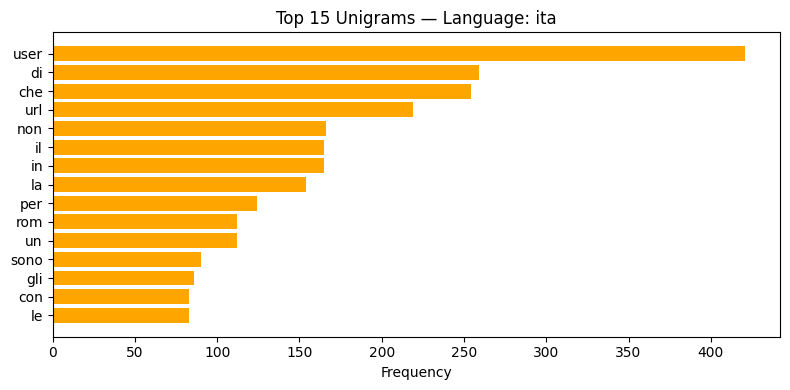

/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2325 (

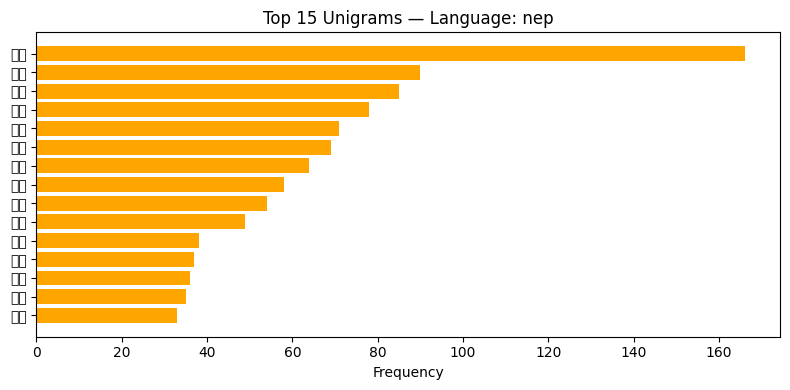

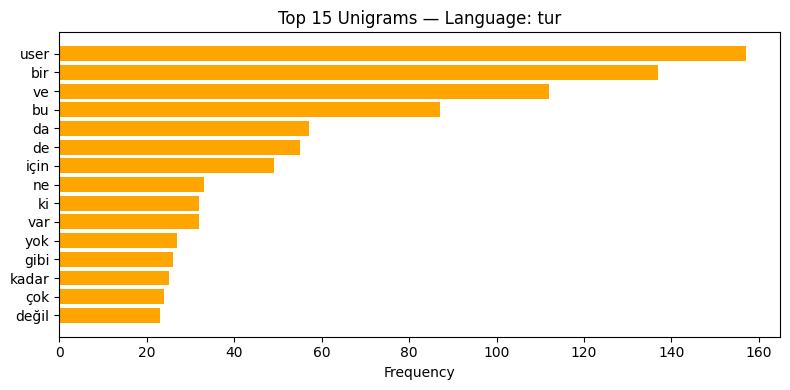

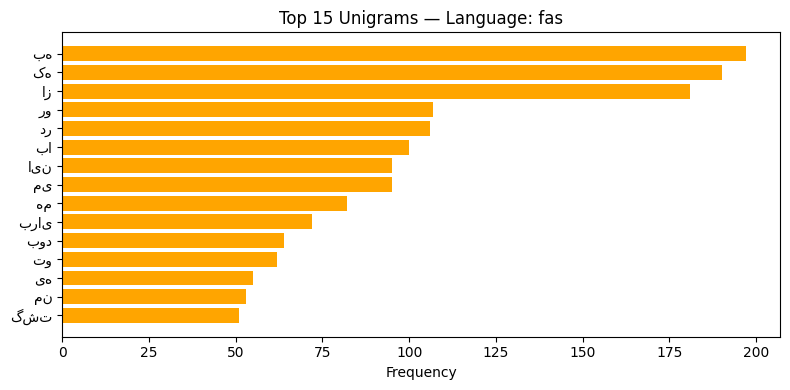

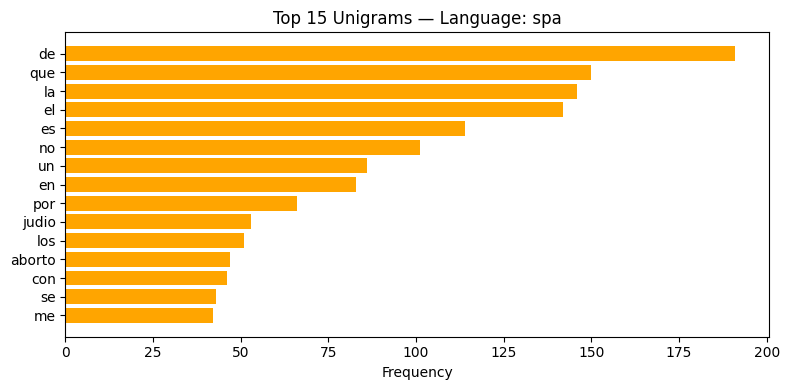

/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4709 (\N{ETHIOPIC SYLLABLE BE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4731 (\N{ETHIOPIC SYLLABLE CAA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4939 (\N{ETHIOPIC SYLLABLE FAA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4758 (\N{ETHIOPIC SYLLABLE NO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4877 (\N{ETHIOPIC SYLLABLE GE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4757 (\N{ETHIOPIC SYLLABLE NE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 4808 (\N{ETHIOPIC SYLLABLE WA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyp

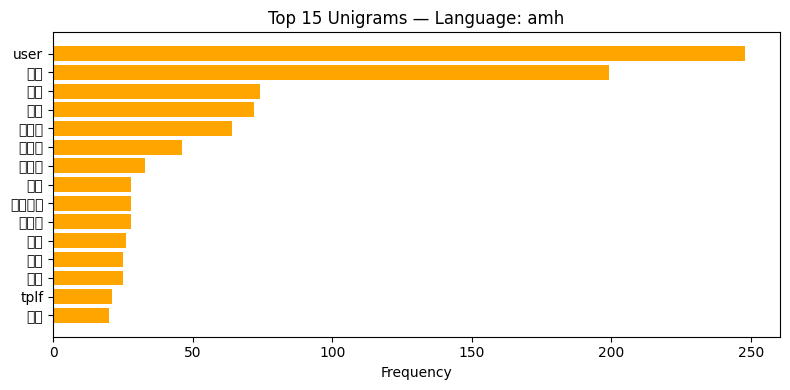

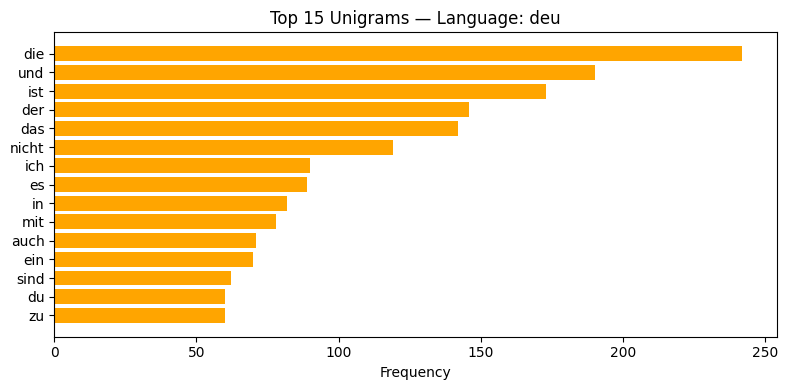

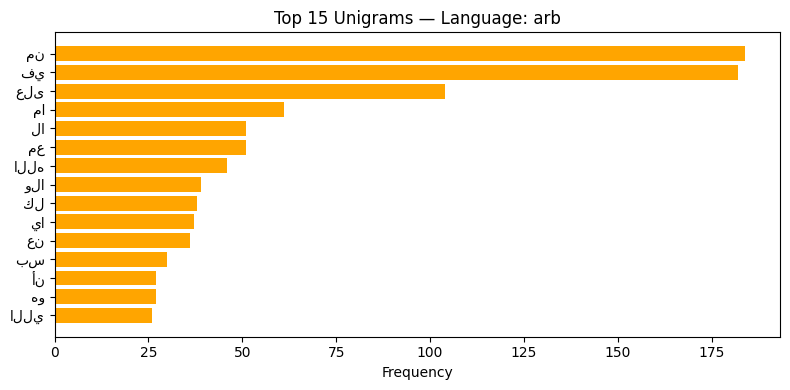

/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 21704 (\N{CJK UNIFIED IDEOGRAPH-54C8}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 20063 (\N{CJK UNIFIED IDEOGRAPH-4E5F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 23601 (\N{CJK UNIFIED IDEOGRAPH-5C31}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.tight_layout()
/tmp/i

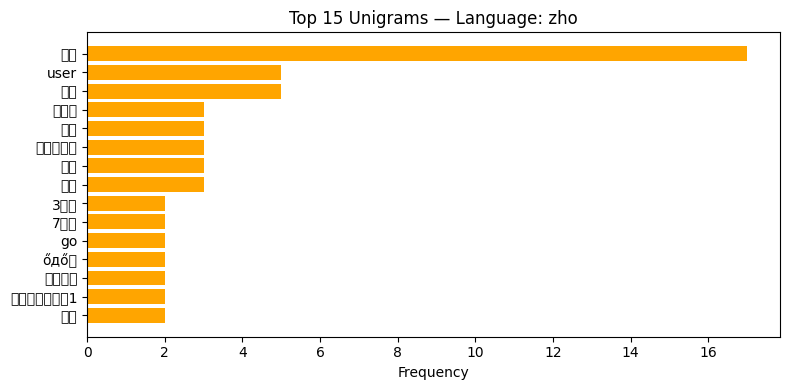

/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2327 (\N{DEVANAGARI LETTER GA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2311 (\N{DEVANAGARI LETTER I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 2352 (

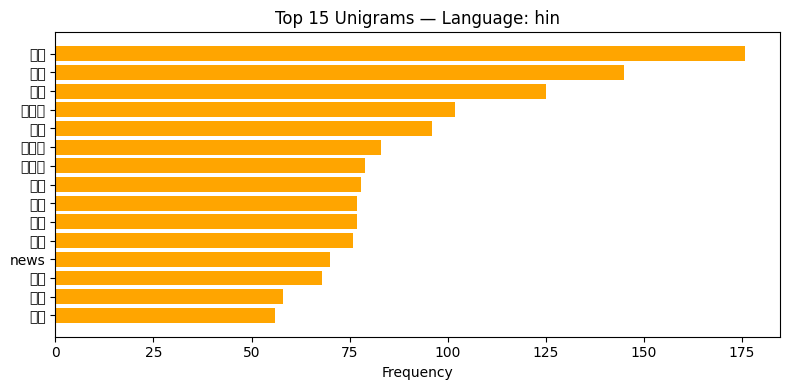

/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_48/1176508308.py:64: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


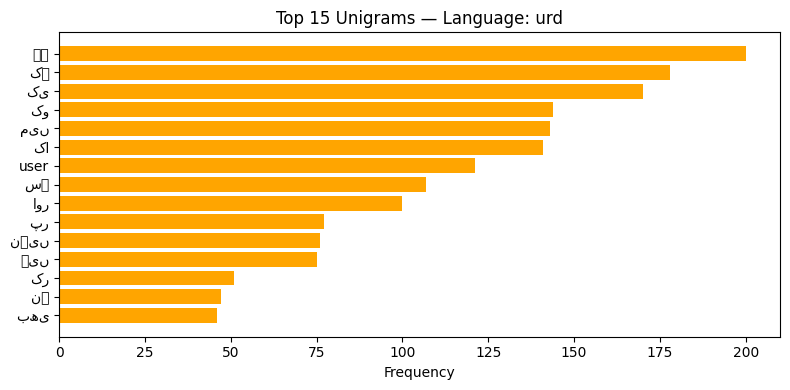

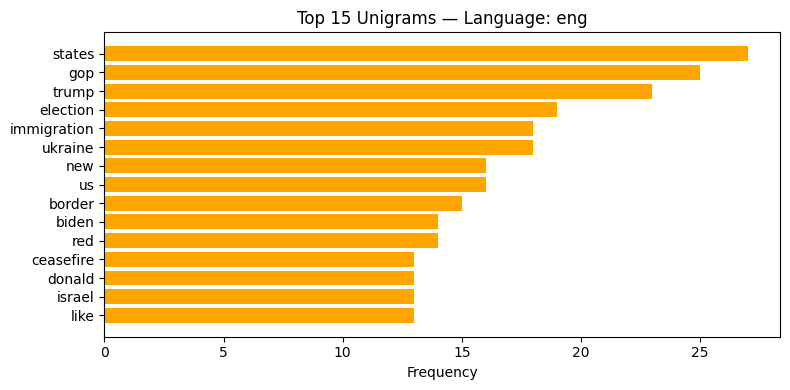

In [14]:
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

EN_STOPWORDS = set(stopwords.words("english"))

# Function to remove English stopwords row-wise
def remove_english_stopwords(text, lang):
    if lang == "eng":
        tokens = re.findall(r"\w+", str(text).lower(), flags=re.UNICODE)
        tokens = [t for t in tokens if t not in EN_STOPWORDS]
        return " ".join(tokens)
    return str(text)

# Function to calculate vocabulary stats for a dataset
def vocab_stats(df, df_name, use_stopwords=False):
    df_copy = df.copy()
    if use_stopwords and "language" in df.columns:
        df_copy["text"] = df_copy.apply(lambda row: remove_english_stopwords(row["text"], row["language"]), axis=1)

    texts = df_copy["text"].dropna().astype(str).tolist()
    tokens = re.findall(r"\w+", " ".join(texts).lower(), flags=re.UNICODE)
    
    vocab = set(tokens)
    freq = Counter(tokens)
    
    print("="*50)
    print(f"{df_name.upper()} — ALL LANGUAGES VOCABULARY")
    print("="*50)
    print(f"Total tokens: {len(tokens):,}")
    print(f"Unique vocabulary: {len(vocab):,}")
    print(f"Type-token ratio: {len(vocab)/len(tokens):.4f}")
    
    return vocab, freq

# Function to show top N unigrams per language
def top_unigrams_per_language(df, n=15, use_stopwords=False):
    df_copy = df.copy()
    if use_stopwords:
        df_copy["text"] = df_copy.apply(lambda row: remove_english_stopwords(row["text"], row["language"]), axis=1)

    languages = df_copy["language"].unique()
    for lang in languages:
        texts = df_copy[df_copy["language"] == lang]["text"].dropna().astype(str).tolist()
        if not texts:
            continue
        vectorizer = CountVectorizer(ngram_range=(1,1))
        try:
            X = vectorizer.fit_transform(texts)
            freqs = X.sum(axis=0).A1
            vocab_features = vectorizer.get_feature_names_out()
            ngram_freqs = sorted(zip(vocab_features, freqs), key=lambda x: x[1], reverse=True)[:n]
            if ngram_freqs:
                words, counts = zip(*ngram_freqs)
                plt.figure(figsize=(8,4))
                plt.barh(words[::-1], counts[::-1], color='orange')
                plt.title(f"Top {n} Unigrams — Language: {lang}")
                plt.xlabel("Frequency")
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Language {lang} plot failed: {e}")

# --- Usage ---

# 1. Train dataset
train_vocab, train_freq = vocab_stats(train, "Train Data", use_stopwords=True)

# 2. Dev dataset
dev_vocab, dev_freq = vocab_stats(dev, "Dev Data", use_stopwords=True)

# 3. Merge train + dev
merged_data = pd.concat([train, dev], ignore_index=True)
print("\nMerged train + dev dataset contains:", merged_data.shape[0], "rows")

# 4. Top unigrams per language for merged data
top_unigrams_per_language(merged_data, n=15, use_stopwords=True)

## Sentiment Analysis

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/concat.py:597: RuntimeWarning: coroutine 'process_sentiment' was never awaited
  all(not ju.is_na or ju.block.is_extension for ju in join_units)


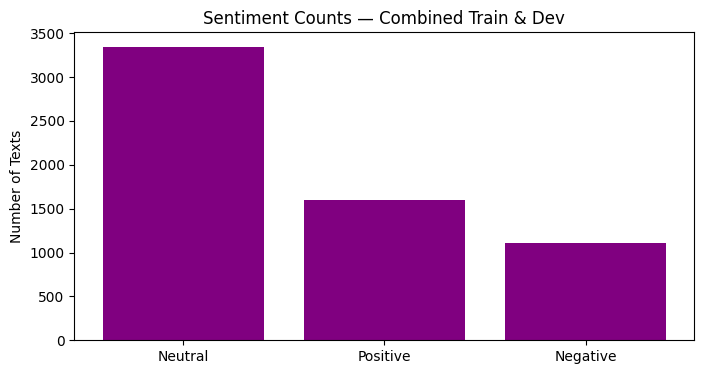

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from googletrans import Translator
import asyncio
import nest_asyncio

nest_asyncio.apply()


combined = pd.concat([train, dev], ignore_index=True)

translator = Translator()

async def translate_and_sentiment(text):
    try:
        translated = await translator.translate(str(text), dest='en')
        polarity = TextBlob(translated.text).sentiment.polarity
        if polarity > 0.1:
            return "Positive"
        elif polarity < -0.1:
            return "Negative"
        else:
            return "Neutral"
    except:
        return "Neutral"

async def process_all(texts):
    tasks = [translate_and_sentiment(t) for t in texts]
    results = await asyncio.gather(*tasks)
    return results

sentiments = asyncio.run(process_all(combined['text'].tolist()))

combined['sentiment'] = sentiments

counts = combined['sentiment'].value_counts()

plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values, color='purple')
plt.title("Sentiment Counts — Combined Train & Dev")
plt.ylabel("Number of Texts")
plt.show()

## Langugae Mix

In [23]:
import pandas as pd
from langdetect import detect_langs, DetectorFactory
DetectorFactory.seed = 0
import re

def detect_languages_full_text(text):
    try:
        langs = detect_langs(str(text))
        return [l.lang for l in langs if l.prob > 0.1]
    except:
        return []

train['detected_languages'] = train['text'].apply(detect_languages_full_text)
train['mixed_language'] = train['detected_languages'].apply(lambda x: len(x) > 1)

dev['detected_languages'] = dev['text'].apply(detect_languages_full_text)
dev['mixed_language'] = dev['detected_languages'].apply(lambda x: len(x) > 1)

print("5 Train examples with mixed languages:")
print(train[train['mixed_language']].head(5)[['id','text','detected_languages']])

print("\n5 Dev examples with mixed languages:")
print(dev[dev['mixed_language']].head(5)[['id','text','detected_languages']])

train_mixed_pct = train['mixed_language'].mean() * 100
dev_mixed_pct = dev['mixed_language'].mean() * 100

print(f"\nPercentage of mixed-language instances:")
print(f"Train: {train_mixed_pct:.2f}%")
print(f"Dev: {dev_mixed_pct:.2f}%")

5 Train examples with mixed languages:
                                      id  \
0   hau_1c40ceef36fad59132cbdcd4e3e7ead2   
6   spa_4d9a373e5043ed3e591702162155d377   
7   hau_22516647fc48d4bbf086c3c9264c72ad   
42  hau_2181124fe59f55e33f7edbc9c361b0d0   
43  hau_43d5a15d95597b2a2bff9aebc8beddf4   

                                                 text detected_languages  
0   @USER bana goyon bayan tankawa kasakasai a sm....       [sw, so, id]  
6   no falla, un ministro ppero es un ministro cor...           [it, es]  
7   @USER ai kasan yadda akwai arna na amana, toh ...       [sw, id, so]  
42  An Mayar da Al’ummar Kano jahilai, wawaye akan...   [so, sw, tl, id]  
43  @USER to sai mi kakannin mu jakai suke hawa da...           [id, sw]  

5 Dev examples with mixed languages:
                                       id  \
174  arb_19dd96c989323c9e950a2c3ab9c285be   
186  arb_e56b759d14fd70506e01cf971315453d   
192  arb_4188caa3678846451bb812d7a7902459   
242  arb_6c8048c166f7ee2e8a9

## Social Media Features

In [16]:
import re
import emoji
import pandas as pd

# Example: train and dev DataFrames already loaded
# train = pd.read_csv("train.csv")
# dev = pd.read_csv("dev.csv")

# Function to count emojis in a text
def count_emojis(text):
    return sum(1 for char in str(text) if char in emoji.EMOJI_DATA)

# Function to extract hashtags
def extract_hashtags(text):
    return re.findall(r"#\w+", str(text))

# Function to extract mentions
def extract_mentions(text):
    return re.findall(r"@\w+", str(text))

# Function to add social media features to a dataset
def add_social_features(df):
    df['emoji_count'] = df['text'].apply(count_emojis)
    df['hashtag_count'] = df['text'].apply(lambda x: len(extract_hashtags(x)))
    df['mention_count'] = df['text'].apply(lambda x: len(extract_mentions(x)))
    return df

# Apply to train and dev datasets
train = add_social_features(train)
dev = add_social_features(dev)

# Quick summary
print("Train dataset social media features summary:")
print(train[['emoji_count', 'hashtag_count', 'mention_count']].head())

print("\nDev dataset social media features summary:")
print(dev[['emoji_count', 'hashtag_count', 'mention_count']].head())

Train dataset social media features summary:
   emoji_count  hashtag_count  mention_count
0            0              0              1
1            0              0              1
2            0              0              0
3            0              0              0
4            0              0              0

Dev dataset social media features summary:
   emoji_count  hashtag_count  mention_count
0            0              0              0
1            0              0              0
2            0              0              0
3            0              0              0
4            0              0              0


In [17]:
# Overall sums for train dataset
train_emoji_sum = train['emoji_count'].sum()
train_hashtag_sum = train['hashtag_count'].sum()
train_mention_sum = train['mention_count'].sum()

print("Train dataset overall counts:")
print(f"Total emojis: {train_emoji_sum}")
print(f"Total hashtags: {train_hashtag_sum}")
print(f"Total mentions: {train_mention_sum}")

# Overall sums for dev dataset
dev_emoji_sum = dev['emoji_count'].sum()
dev_hashtag_sum = dev['hashtag_count'].sum()
dev_mention_sum = dev['mention_count'].sum()

print("\nDev dataset overall counts:")
print(f"Total emojis: {dev_emoji_sum}")
print(f"Total hashtags: {dev_hashtag_sum}")
print(f"Total mentions: {dev_mention_sum}")

Train dataset overall counts:
Total emojis: 672
Total hashtags: 933
Total mentions: 978

Dev dataset overall counts:
Total emojis: 358
Total hashtags: 459
Total mentions: 515
